## Урок 4. Домашнее задание

In [138]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [139]:
df = pd.read_csv('data.csv')
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [140]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1)
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

   treatment  target  
0          1       0  
1          0       0  
2          1       0  
3          1       0  
4          1       0

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [141]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [142]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



continuos_cols = ['recency', 'history']
cat_cols = ['zip_code', 'channel']
base_cols = ['used_discount', 'used_bogo', 'is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [143]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

treatment_train = X_train['treatment']
treatment_test = X_test['treatment']

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [144]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
#     'uplift@30%': [],
}

In [145]:
# SoloModel
model1 = Pipeline([
    ('features',feats),
    ('model', SoloModel(LogisticRegression(random_state=42))),
])


# Трансформация классов
model2 = Pipeline([
    ('features',feats),
    ('model', ClassTransformation(LogisticRegression(random_state=42))),
])


# Две независимые модели
model3 = Pipeline([
    ('features',feats),
    ('model', TwoModels(estimator_trmnt=LogisticRegression(random_state=42), 
                        estimator_ctrl=LogisticRegression(random_state=42), 
                        method='vanilla')),
])


models = [model1, model2, model3]

for model in models:
    model.fit(X_train, y_train, model__treatment=treatment_train)
    uplift = model.predict(X_test)
    score_10 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='by_group', k=0.1)
    score_20 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='by_group', k=0.2)
#     score_30 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='by_group', k=0.3)
    models_results['uplift@10%'].append(score_10)
    models_results['uplift@20%'].append(score_20)
#     models_results['uplift@30%'].append(score_30)
    
models_results['approach']= ['SoloModel', 'ClassTransformation', 'TwoModels']

In [146]:
pd.DataFrame(data=models_results)

approach  uplift@10%  uplift@20%
0            SoloModel    0.116104    0.099717
1  ClassTransformation    0.137222    0.107499
2            TwoModels    0.131612    0.110804

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [147]:
Z_train = X_train.drop(columns=['treatment'])
features = Z_train.columns.to_list()

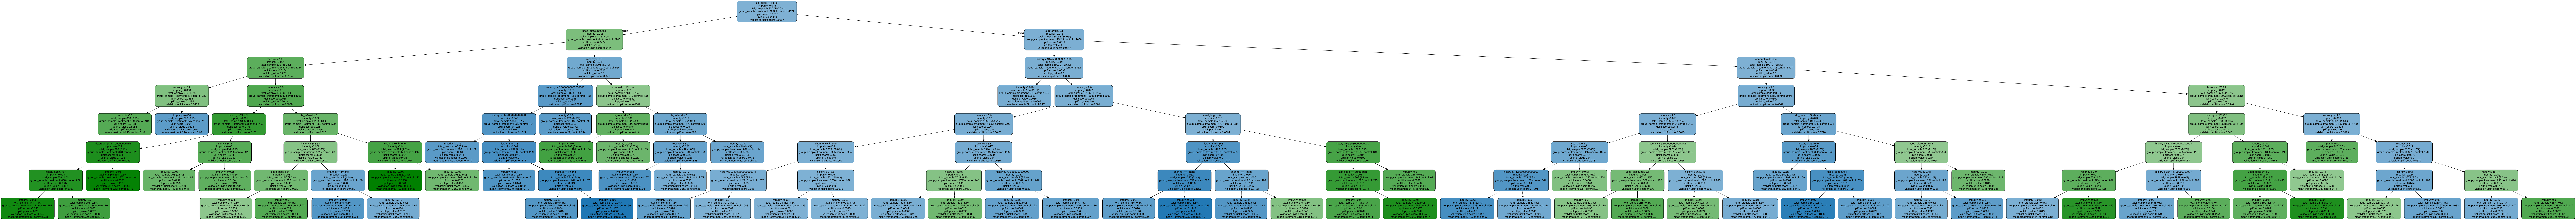

In [148]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(Z_train.values,
                 y=y_train.values,
                 treatment=treatment_train.map({1: 'treatment', 0: 'control'}).values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
graph.write_png('tree.png')
Image(graph.create_png())

Как видно из построенного рисунка на начальном этапе разбиение происходит на основе региона почтового индекса, на следюущем этапе влияние оказывает пришел ли клиент по реферальной программе и пользовался ли скидочными предложения до этого...

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [149]:
model1.fit(X_train, y_train, model__treatment=treatment_train)
uplift1 = model1.predict(X_test)
up_conv = pd.DataFrame(
    {'uplift': uplift1, 'conversion': y_test}).sort_values('uplift', ascending=False)
pd.DataFrame(
    up_conv.groupby(pd.qcut(up_conv['uplift'],q=10))['conversion'].mean()).sort_values('uplift', ascending=False)

conversion
uplift                      
(0.0838, 0.126]     0.256771
(0.0742, 0.0838]    0.210938
(0.0673, 0.0742]    0.171875
(0.0614, 0.0673]    0.162500
(0.0561, 0.0614]    0.155208
(0.0512, 0.0561]    0.138542
(0.0464, 0.0512]    0.117188
(0.0408, 0.0464]    0.108854
(0.0347, 0.0408]    0.093570
(0.0224, 0.0347]    0.048780

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [153]:
uplift_forest = UpliftRandomForestClassifier(n_estimators=7, min_samples_leaf=150, min_samples_treatment=50, 
                                             n_reg=50, evaluationFunction='KL', control_name='control')

uplift_forest.fit(Z_train.values,
                 y=y_train.values,
                 treatment=treatment_train.map({1: 'treatment', 0: 'control'}).values)

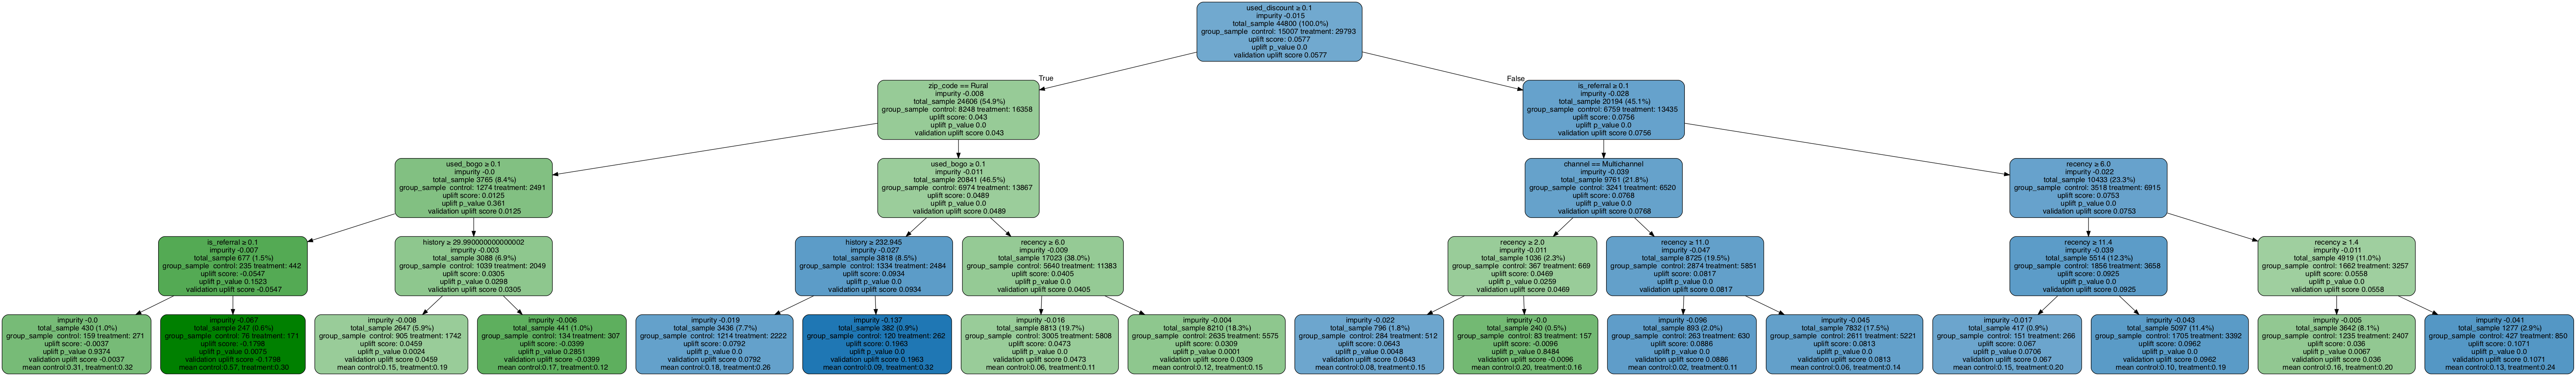

In [154]:
# Визуализируем несколько деревьев из леса

tree0 = uplift_forest.uplift_forest[0]
graph = uplift_tree_plot(tree0.fitted_uplift_tree, features)
graph.write_png('forest_tree_0.png')
Image(graph.create_png())

В этом дереве начальное разделение происходит на основе того, пользовался ли ранее клиент скидками, далее рассматриваются регион почтового индекса клиента, а также пришел ли он по реферальной программе ... Значения `validation uplift score` на узлах, близких к корню, положительные.

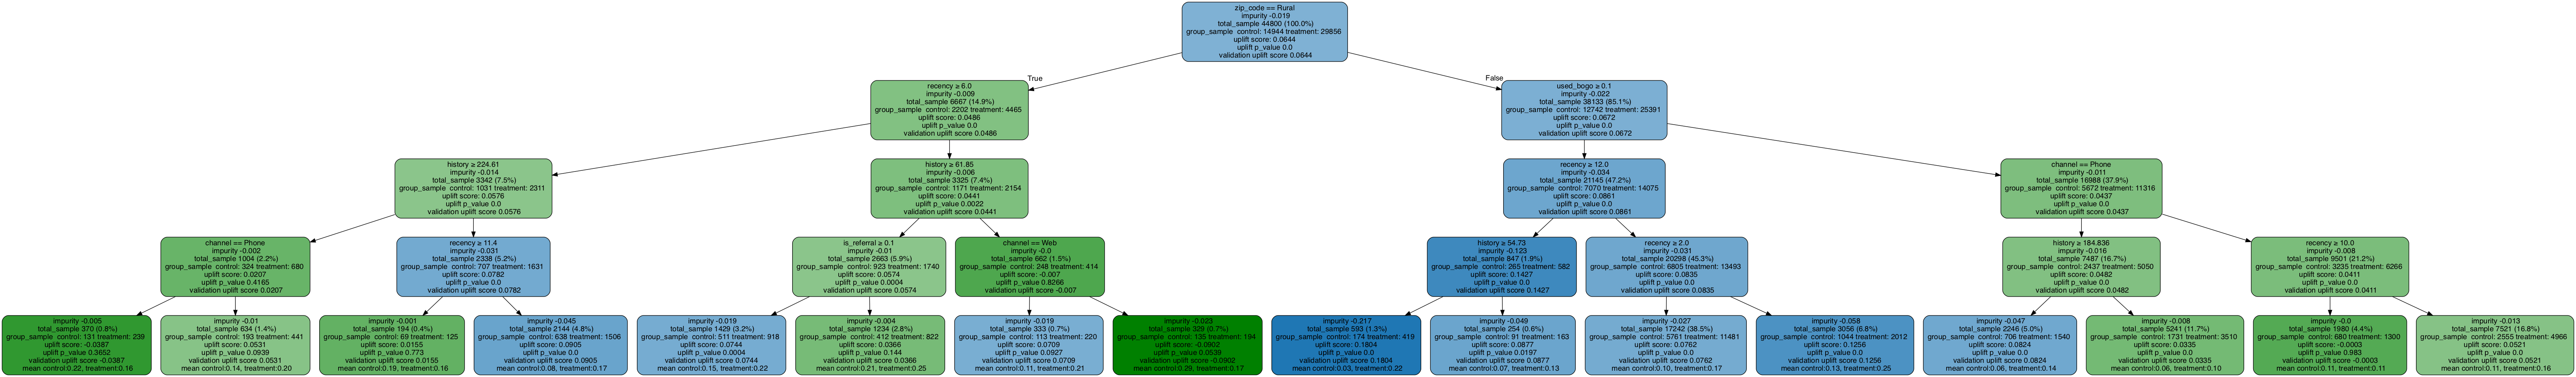

In [155]:
tree1 = uplift_forest.uplift_forest[1]
graph = uplift_tree_plot(tree1.fitted_uplift_tree, features)
graph.write_png('forest_tree_1.png')
Image(graph.create_png())

Здесь разбиение начинается с региона, к которому относится почтовый индекс покупателя, затем разбиение происходит по количеству месяцев, прошедших с момента последней покупки, а также на основе того, пользовался ли клиент раньше специальными акционными предложениями ...